In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install import_ipynb
from keras.models import Model
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import import_ipynb
from reccnn import RecCNN
from comcnn import ComCNN


Using TensorFlow backend.


importing Jupyter notebook from reccnn.ipynb
importing Jupyter notebook from comcnn.ipynb


In [0]:
import matplotlib.image as mpimg
from PIL import Image
import os

def compressThis(x_input):
    # x_input dimension (num, x, y, c)
    # num - number of images
    num = x_input.shape[0]
    ans = []
    for i in range(num):
        x_single = x_input[i]
        # compressing single image
        mpimg.imsave(os.getcwd()+'/org.JPEG', x_single)
        tmp = Image.open(os.getcwd()+'/org.JPEG')
        tmp.save(os.getcwd()+'/com.JPEG',"JPEG", optimize=True, quality=65)
        out_single = mpimg.imread(os.getcwd()+'/com.JPEG')
        ans.append(out_single)
        
    return np.array(ans)
        

In [4]:
!pip install tqdm
from tqdm import tqdm
import os
import matplotlib.image as mpimg
import cv2

loc = '/content/drive/My Drive/Subset16k'

count1 = 0
X = []
for i in os.listdir(loc):
  count1 = count1 + 1
  if count1 == 6000:
    break
  if count1%100==0:
    print(count1)
  
  im_loc = loc + '/'+i
  img = cv2.imread(im_loc)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  X.append(img)
    

X = np.array(X)
# print(X[0])
print(X.shape)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
(5999, 256, 256, 3)


In [5]:
print(X.shape)

(5999, 256, 256, 3)


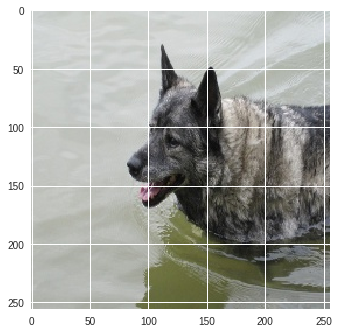

In [6]:
#checking images
import matplotlib.pyplot as plt
plt.imshow(X[0])
plt.show()

In [7]:
x_train = X[:4800,:,:,:]
x_test = X[4800:,:,:,:]
print(x_train.shape)
print(x_test.shape)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255
x_test = x_test / 255


(4800, 256, 256, 3)
(1199, 256, 256, 3)


In [8]:
from keras.layers import Input
from keras.callbacks import ModelCheckpoint
import tensorflow as tf


inp2 = Input(shape=(64, 64, 3))
rec_cnn = RecCNN(3)
model_reccnn = Model(inp2, rec_cnn.fsrcnn(inp2))
model_reccnn.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
checkpointr = ModelCheckpoint(filepath='reccnn.weights.best.hdf5', save_best_only=True, verbose=1)
model_reccnn.summary()

inp1 = Input(shape=(256, 256, 3))
com_cnn = ComCNN(3)
model_comcnn = Model(inp1, model_reccnn(com_cnn.compact(inp1)))
model_comcnn.layers[4].trainable = False
model_comcnn.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
checkpointc = ModelCheckpoint(filepath='comcnn.weights.best.hdf5', save_best_only=True, verbose=1)
model_comcnn.summary()


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 56)        4256      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 12)        684       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 12)        1308      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 12)        1308      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 12)        1308      
_________________________________________________________________
conv

In [9]:
count = 25
x_valid = x_test

for i in tqdm(range(count)):
  
#   print("------- Count : " + str(count)+" ---------")
  
  # calculating cm using comcnn
  upto_comcnn = Model(model_comcnn.input, model_comcnn.layers[3].output)
  xm = upto_comcnn.predict(x_train)
  xm_valid = upto_comcnn.predict(x_valid)

  
  # train RecCNN
  model_reccnn.fit(x=xm, y=x_train, validation_data=(xm_valid, x_valid),epochs=5, shuffle=True, verbose=1, batch_size=8, callbacks=[checkpointr])
  
  # train ComCNN
  model_comcnn.fit(x=x_train, y=x_train, validation_data=(x_valid, x_valid),epochs=5, shuffle=True, verbose=1, batch_size=8, callbacks=[checkpointc])
  

  0%|          | 0/25 [00:00<?, ?it/s]

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Train on 4800 samples, validate on 1199 samples
Epoch 1/5
4800/4800 [==============================] - 15s 3ms/step - loss: 0.0822 - acc: 0.5320 - val_loss: 0.0780 - val_acc: 0.5730

Epoch 00001: val_loss improved from inf to 0.07803, saving model to reccnn.weights.best.hdf5
Epoch 2/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.0772 - acc: 0.5544 - val_loss: 0.0779 - val_acc: 0.5746

Epoch 00002: val_loss improved from 0.07803 to 0.07788, saving model to reccnn.weights.best.hdf5
Epoch 3/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.0771 - acc: 0.5585 - val_loss: 0.0780 - val_acc: 0.5784

Epoch 00003: val_loss did not improve from 0.07788
Epoch 4/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.0771 - acc: 0.5588 - val_loss: 0.0778 - val_acc: 0.5761

Epoch 00004: val_loss improved from 0.07788 to 0.07783, saving model to reccnn.weights.best.hdf5
Epoch 5/5
4800/4800 [==============================] - 14s 3ms/step - loss

  4%|▍         | 1/25 [05:41<2:16:38, 341.59s/it]


Epoch 00005: val_loss improved from 0.07680 to 0.07679, saving model to comcnn.weights.best.hdf5
Train on 4800 samples, validate on 1199 samples
Epoch 1/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.0275 - acc: 0.5104 - val_loss: 0.0243 - val_acc: 0.4594

Epoch 00001: val_loss improved from 0.07783 to 0.02426, saving model to reccnn.weights.best.hdf5
Epoch 2/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.0232 - acc: 0.4933 - val_loss: 0.0250 - val_acc: 0.5152

Epoch 00002: val_loss did not improve from 0.02426
Epoch 3/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.0220 - acc: 0.4888 - val_loss: 0.0223 - val_acc: 0.5453

Epoch 00003: val_loss improved from 0.02426 to 0.02228, saving model to reccnn.weights.best.hdf5
Epoch 4/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.0212 - acc: 0.4864 - val_loss: 0.0216 - val_acc: 0.4201

Epoch 00004: val_loss improved from 0.02228 to 0.02156, saving model 

  8%|▊         | 2/25 [11:17<2:10:15, 339.79s/it]


Epoch 00005: val_loss improved from 0.01572 to 0.01563, saving model to comcnn.weights.best.hdf5
Train on 4800 samples, validate on 1199 samples
Epoch 1/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.0139 - acc: 0.5023 - val_loss: 0.0134 - val_acc: 0.5718

Epoch 00001: val_loss improved from 0.02107 to 0.01342, saving model to reccnn.weights.best.hdf5
Epoch 2/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.0133 - acc: 0.5046 - val_loss: 0.0136 - val_acc: 0.5404

Epoch 00002: val_loss did not improve from 0.01342
Epoch 3/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.0133 - acc: 0.5029 - val_loss: 0.0131 - val_acc: 0.4986

Epoch 00003: val_loss improved from 0.01342 to 0.01312, saving model to reccnn.weights.best.hdf5
Epoch 4/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.0130 - acc: 0.4985 - val_loss: 0.0126 - val_acc: 0.5513

Epoch 00004: val_loss improved from 0.01312 to 0.01263, saving model 

 12%|█▏        | 3/25 [16:48<2:03:37, 337.18s/it]


Epoch 00005: val_loss did not improve from 0.01123
Train on 4800 samples, validate on 1199 samples
Epoch 1/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.0087 - acc: 0.5665 - val_loss: 0.0083 - val_acc: 0.6182

Epoch 00001: val_loss improved from 0.01263 to 0.00831, saving model to reccnn.weights.best.hdf5
Epoch 2/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.0080 - acc: 0.5775 - val_loss: 0.0088 - val_acc: 0.4650

Epoch 00002: val_loss did not improve from 0.00831
Epoch 3/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.0077 - acc: 0.5850 - val_loss: 0.0086 - val_acc: 0.5162

Epoch 00003: val_loss did not improve from 0.00831
Epoch 4/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.0076 - acc: 0.5951 - val_loss: 0.0076 - val_acc: 0.5895

Epoch 00004: val_loss improved from 0.00831 to 0.00764, saving model to reccnn.weights.best.hdf5
Epoch 5/5
4800/4800 [==============================] - 14s 3ms/s

 16%|█▌        | 4/25 [22:21<1:57:37, 336.09s/it]


Epoch 00005: val_loss did not improve from 0.00707
Train on 4800 samples, validate on 1199 samples
Epoch 1/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.0066 - acc: 0.6349 - val_loss: 0.0067 - val_acc: 0.6104

Epoch 00001: val_loss improved from 0.00764 to 0.00666, saving model to reccnn.weights.best.hdf5
Epoch 2/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.0064 - acc: 0.6387 - val_loss: 0.0067 - val_acc: 0.5900

Epoch 00002: val_loss did not improve from 0.00666
Epoch 3/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.0063 - acc: 0.6402 - val_loss: 0.0065 - val_acc: 0.6000

Epoch 00003: val_loss improved from 0.00666 to 0.00646, saving model to reccnn.weights.best.hdf5
Epoch 4/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.0061 - acc: 0.6432 - val_loss: 0.0071 - val_acc: 0.6313

Epoch 00004: val_loss did not improve from 0.00646
Epoch 5/5
4800/4800 [==============================] - 14s 3ms/s

 20%|██        | 5/25 [27:55<1:51:46, 335.33s/it]


Epoch 00005: val_loss did not improve from 0.00594
Train on 4800 samples, validate on 1199 samples
Epoch 1/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.0056 - acc: 0.6516 - val_loss: 0.0058 - val_acc: 0.6757

Epoch 00001: val_loss improved from 0.00633 to 0.00582, saving model to reccnn.weights.best.hdf5
Epoch 2/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.0055 - acc: 0.6488 - val_loss: 0.0056 - val_acc: 0.6274

Epoch 00002: val_loss improved from 0.00582 to 0.00560, saving model to reccnn.weights.best.hdf5
Epoch 3/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.0054 - acc: 0.6561 - val_loss: 0.0056 - val_acc: 0.6256

Epoch 00003: val_loss improved from 0.00560 to 0.00558, saving model to reccnn.weights.best.hdf5
Epoch 4/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.0054 - acc: 0.6506 - val_loss: 0.0055 - val_acc: 0.6434

Epoch 00004: val_loss improved from 0.00558 to 0.00547, saving model 

 24%|██▍       | 6/25 [33:29<1:46:03, 334.92s/it]


Epoch 00005: val_loss improved from 0.00534 to 0.00533, saving model to comcnn.weights.best.hdf5
Train on 4800 samples, validate on 1199 samples
Epoch 1/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.0051 - acc: 0.6615 - val_loss: 0.0053 - val_acc: 0.6946

Epoch 00001: val_loss improved from 0.00547 to 0.00525, saving model to reccnn.weights.best.hdf5
Epoch 2/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.0051 - acc: 0.6597 - val_loss: 0.0052 - val_acc: 0.6752

Epoch 00002: val_loss improved from 0.00525 to 0.00522, saving model to reccnn.weights.best.hdf5
Epoch 3/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.0051 - acc: 0.6597 - val_loss: 0.0052 - val_acc: 0.7126

Epoch 00003: val_loss did not improve from 0.00522
Epoch 4/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.0050 - acc: 0.6623 - val_loss: 0.0052 - val_acc: 0.6704

Epoch 00004: val_loss improved from 0.00522 to 0.00519, saving model 

 28%|██▊       | 7/25 [39:03<1:40:22, 334.57s/it]


Epoch 00005: val_loss did not improve from 0.00505
Train on 4800 samples, validate on 1199 samples
Epoch 1/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.0050 - acc: 0.6623 - val_loss: 0.0051 - val_acc: 0.6532

Epoch 00001: val_loss improved from 0.00519 to 0.00512, saving model to reccnn.weights.best.hdf5
Epoch 2/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.0049 - acc: 0.6701 - val_loss: 0.0051 - val_acc: 0.6503

Epoch 00002: val_loss did not improve from 0.00512
Epoch 3/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.0049 - acc: 0.6754 - val_loss: 0.0049 - val_acc: 0.7142

Epoch 00003: val_loss improved from 0.00512 to 0.00492, saving model to reccnn.weights.best.hdf5
Epoch 4/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.0048 - acc: 0.6888 - val_loss: 0.0051 - val_acc: 0.6598

Epoch 00004: val_loss did not improve from 0.00492
Epoch 5/5
4800/4800 [==============================] - 14s 3ms/s

 32%|███▏      | 8/25 [44:34<1:34:33, 333.76s/it]


Epoch 00005: val_loss improved from 0.00465 to 0.00463, saving model to comcnn.weights.best.hdf5
Train on 4800 samples, validate on 1199 samples
Epoch 1/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.0044 - acc: 0.7533 - val_loss: 0.0045 - val_acc: 0.7543

Epoch 00001: val_loss improved from 0.00492 to 0.00449, saving model to reccnn.weights.best.hdf5
Epoch 2/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.0044 - acc: 0.7572 - val_loss: 0.0046 - val_acc: 0.7582

Epoch 00002: val_loss did not improve from 0.00449
Epoch 3/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.0043 - acc: 0.7602 - val_loss: 0.0045 - val_acc: 0.7781

Epoch 00003: val_loss improved from 0.00449 to 0.00446, saving model to reccnn.weights.best.hdf5
Epoch 4/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.0043 - acc: 0.7619 - val_loss: 0.0044 - val_acc: 0.7841

Epoch 00004: val_loss improved from 0.00446 to 0.00444, saving model 

 36%|███▌      | 9/25 [50:05<1:28:44, 332.76s/it]


Epoch 00005: val_loss did not improve from 0.00427
Train on 4800 samples, validate on 1199 samples
Epoch 1/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.0041 - acc: 0.7754 - val_loss: 0.0046 - val_acc: 0.7274

Epoch 00001: val_loss did not improve from 0.00444
Epoch 2/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.0041 - acc: 0.7739 - val_loss: 0.0043 - val_acc: 0.7942

Epoch 00002: val_loss improved from 0.00444 to 0.00426, saving model to reccnn.weights.best.hdf5
Epoch 3/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.0041 - acc: 0.7801 - val_loss: 0.0047 - val_acc: 0.7341

Epoch 00003: val_loss did not improve from 0.00426
Epoch 4/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.0041 - acc: 0.7748 - val_loss: 0.0044 - val_acc: 0.7803

Epoch 00004: val_loss did not improve from 0.00426
Epoch 5/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.0040 - acc: 0.7829 - val_loss: 0

 40%|████      | 10/25 [55:35<1:22:57, 331.85s/it]


Epoch 00005: val_loss did not improve from 0.00403
Train on 4800 samples, validate on 1199 samples
Epoch 1/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.0039 - acc: 0.7866 - val_loss: 0.0040 - val_acc: 0.8046

Epoch 00001: val_loss improved from 0.00416 to 0.00401, saving model to reccnn.weights.best.hdf5
Epoch 2/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.0039 - acc: 0.7877 - val_loss: 0.0040 - val_acc: 0.8053

Epoch 00002: val_loss improved from 0.00401 to 0.00400, saving model to reccnn.weights.best.hdf5
Epoch 3/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.0039 - acc: 0.7918 - val_loss: 0.0041 - val_acc: 0.8095

Epoch 00003: val_loss did not improve from 0.00400
Epoch 4/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.0039 - acc: 0.7878 - val_loss: 0.0040 - val_acc: 0.8193

Epoch 00004: val_loss improved from 0.00400 to 0.00396, saving model to reccnn.weights.best.hdf5
Epoch 5/5
4800/480

 44%|████▍     | 11/25 [1:01:06<1:17:24, 331.73s/it]


Epoch 00005: val_loss did not improve from 0.00394
Train on 4800 samples, validate on 1199 samples
Epoch 1/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.0037 - acc: 0.7973 - val_loss: 0.0041 - val_acc: 0.7615

Epoch 00001: val_loss did not improve from 0.00396
Epoch 2/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.0038 - acc: 0.7919 - val_loss: 0.0043 - val_acc: 0.7759

Epoch 00002: val_loss did not improve from 0.00396
Epoch 3/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.0038 - acc: 0.7904 - val_loss: 0.0039 - val_acc: 0.7707

Epoch 00003: val_loss improved from 0.00396 to 0.00392, saving model to reccnn.weights.best.hdf5
Epoch 4/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.0037 - acc: 0.7968 - val_loss: 0.0040 - val_acc: 0.8221

Epoch 00004: val_loss did not improve from 0.00392
Epoch 5/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.0037 - acc: 0.7968 - val_loss: 0

 48%|████▊     | 12/25 [1:06:37<1:11:51, 331.65s/it]


Epoch 00005: val_loss did not improve from 0.00380
Train on 4800 samples, validate on 1199 samples
Epoch 1/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.0036 - acc: 0.8030 - val_loss: 0.0038 - val_acc: 0.7849

Epoch 00001: val_loss improved from 0.00392 to 0.00384, saving model to reccnn.weights.best.hdf5
Epoch 2/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.0036 - acc: 0.8017 - val_loss: 0.0038 - val_acc: 0.8132

Epoch 00002: val_loss improved from 0.00384 to 0.00383, saving model to reccnn.weights.best.hdf5
Epoch 3/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.0037 - acc: 0.7954 - val_loss: 0.0040 - val_acc: 0.7702

Epoch 00003: val_loss did not improve from 0.00383
Epoch 4/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.0036 - acc: 0.8023 - val_loss: 0.0040 - val_acc: 0.7571

Epoch 00004: val_loss did not improve from 0.00383
Epoch 5/5
4800/4800 [==============================] - 14s 3ms/s

 52%|█████▏    | 13/25 [1:12:09<1:06:18, 331.57s/it]


Epoch 00005: val_loss improved from 0.00372 to 0.00372, saving model to comcnn.weights.best.hdf5
Train on 4800 samples, validate on 1199 samples
Epoch 1/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.0036 - acc: 0.8032 - val_loss: 0.0042 - val_acc: 0.8105

Epoch 00001: val_loss did not improve from 0.00378
Epoch 2/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.0036 - acc: 0.8015 - val_loss: 0.0038 - val_acc: 0.7954

Epoch 00002: val_loss did not improve from 0.00378
Epoch 3/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.0036 - acc: 0.8037 - val_loss: 0.0038 - val_acc: 0.8019

Epoch 00003: val_loss did not improve from 0.00378
Epoch 4/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.0035 - acc: 0.8049 - val_loss: 0.0039 - val_acc: 0.7565

Epoch 00004: val_loss did not improve from 0.00378
Epoch 5/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.0036 - acc: 0.8015 - val_loss: 0

 56%|█████▌    | 14/25 [1:17:40<1:00:46, 331.47s/it]


Epoch 00005: val_loss did not improve from 0.00367
Train on 4800 samples, validate on 1199 samples
Epoch 1/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.0036 - acc: 0.7994 - val_loss: 0.0039 - val_acc: 0.7825

Epoch 00001: val_loss did not improve from 0.00368
Epoch 2/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.0035 - acc: 0.8035 - val_loss: 0.0037 - val_acc: 0.8260

Epoch 00002: val_loss did not improve from 0.00368
Epoch 3/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.0036 - acc: 0.7996 - val_loss: 0.0039 - val_acc: 0.7590

Epoch 00003: val_loss did not improve from 0.00368
Epoch 4/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.0035 - acc: 0.7977 - val_loss: 0.0039 - val_acc: 0.8176

Epoch 00004: val_loss did not improve from 0.00368
Epoch 5/5
4800/4800 [==============================] - 14s 3ms/step - loss: 0.0035 - acc: 0.7998 - val_loss: 0.0037 - val_acc: 0.8052

Epoch 00005: val_loss